# Feature Engineering - Time Series pour modèle ensembliste
## Application à la prédiction de ventes (Kaggle Rossmann)


**Petit descriptif du challenge**<br/>
"Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to **predict 6 weeks of daily sales for 1,115 stores** located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams!"



In [1]:
%pylab inline

pylab.rcParams['figure.figsize'] = (15.0, 10.0)
pylab.rcParams['figure.dpi'] = 150

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
import numpy as np

## Chargement de la donnée

Deux datasets sont fournis pour l'apprentissage + un dataset de test à soumettre sur la page Kaggle.
<ul>
<li>**train.csv** dataset avec les ventes du 2013-01-01 au 2015-07-31</li>
<li>**store.csv** dataset avec des données descriptives sur les magasins</li>
<li>**test.csv** dataset avec les ventes à prédire du 2015-08-01 au 2015-09-17</li>
</ul>

In [4]:
shop_data = pd.read_csv('../tests_data/rossmann/train.csv.zip', nrows=200000)

In [5]:
extra_data = pd.read_csv('../tests_data/rossmann/store.csv.zip', nrows=200000)

In [6]:
shop_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
shop_data.shape

(99, 9)

In [8]:
shop_data['Date'].min()

'2015-07-31'

In [9]:
shop_data['Date'].max()

'2015-07-31'

In [10]:
len(shop_data['Store'].unique())

99

Utile pour extraire des infos (mois, etc.) et pour l'affichage de graphiques.

In [11]:
shop_data['Datetime'] = pd.to_datetime(shop_data['Date'], format='%Y-%m-%d')

On ne garde que les lignes où les magasins étaient ouverts, sinon le modèle va apprendre sur des fausses cibles à 0. 

In [12]:
shop_data = shop_data[shop_data['Open'] == 1]

In [13]:
shop_data.shape

(99, 10)

## Feature Engineering

### Feature Engineering basique

In [14]:
from bdacore.preprocessing.feature_extraction import transform_datetxt2int, TagEncoder

On code une petite fonction permettant de label encodé des variables catégorielles, tout en gardant un dictionnaire de TagEncoder quand on aura besoin de l'appliquer au dataset de test.

In [15]:
def label_encode(X,col_list, te_dict=None):
    
    if te_dict is None:
        te_dict = {}
        for col in col_list:
            te = TagEncoder()
            X[col] = te.fit_transform(X[col])
            te_dict[col] = te
    else:
        for col in col_list:
            X[col] = te_dict[col].transform(X[col])
        
    return te_dict

In [16]:
def create_simple_features(X, te_dict=None):
    transform_datetxt2int(X,'Date', format='%Y-%m-%d')
    X['month'] = X['Datetime'].apply(lambda x: x.month)
    X['week'] = X['Datetime'].apply(lambda x: x.week)
    
    col_list = ['StateHoliday']
    if te_dict is None:
        te_dict = label_encode(X,col_list)
        return te_dict
    else:
        label_encode(X,col_list,te_dict)

### Feature Engineering temporel

In [17]:
from bdacore.preprocessing.feature_extraction import create_diff_shift_features
from bdacore.preprocessing.ts.rolling import RollingWindower
from bdacore.preprocessing import Shifter

Un grosse fonction (qu'il faudrait découper en prod) qui génère tout un tas de features temporelles. Certains aspects métier sont codés en dur. Le fait d'avoir retiré les lignes où les magasins étaient fermés fait qu'une semaine est composée de 6 jours (donc lignes), d'où la raison d'avoir des valeur de ranges multiple de 6. On a comme objectif de prédire à 6 semaines, mais le dataset de test contient quasi 7 semaines, donc on s'interdit d'utiliser des variables qui remontent à moins de 7 semaines, soit 7*6 = 42.

In [18]:
def create_timeseries_features(X, features=['Sales']):
    
    shift_ranges = [42,48] + list(range(54,312,24)) + [312]
    
    X_ts = X.sort_values(['Store', 'Date'])
    
    # rolling windows features
    for operation in ['mean','std','median','min','max']:
        roller = RollingWindower(operation=operation, windows=[6,26,78], min_periods=1)
        X_roll = roller.transform(X_ts.groupby('Store')[features]).reset_index(0,drop=False)
        roll_shifter = Shifter(shifts=shift_ranges, prefix='d-')
        X_roll_shifted = roll_shifter.transform(X_roll.groupby('Store'))
        X_ts = X_ts.join(X_roll_shifted)
        
    # shift features
    shifter = Shifter(shifts=shift_ranges, prefix='d-')
    X_shifted = shifter.transform(X_ts[features + ['Store']].groupby('Store'))
    
    # diff shift features
    for feat in features:
        cols_to_diff = []
        for col in X_shifted.columns:
            if feat in col:
                cols_to_diff.append(col)
        create_diff_shift_features(X_shifted, cols=cols_to_diff)
    X_ts = X_ts.join(X_shifted)
    
    # diff mean features
    for rol_shift in shift_ranges:
        X_ts['d-' + str(rol_shift) + '_diff_Sales_mean_6'] = \
            X_ts['d-' + str(rol_shift) + '_Sales'] - X_ts['d-' + str(rol_shift) + '_mean_6_Sales']
    
    X_ts = X_ts.fillna(method='backfill')
    X_ts = X_ts.fillna(method='ffill')
    return X_ts

### Exécution du Feature Engineering

#### Création des features basiques "inplace"

In [19]:
te_dict = create_simple_features(shop_data)

In [20]:
shop_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Datetime,month,week
0,1,5,20150731,5263,555,1,1,0,1,2015-07-31,7,31
1,2,5,20150731,6064,625,1,1,0,1,2015-07-31,7,31
2,3,5,20150731,8314,821,1,1,0,1,2015-07-31,7,31
3,4,5,20150731,13995,1498,1,1,0,1,2015-07-31,7,31
4,5,5,20150731,4822,559,1,1,0,1,2015-07-31,7,31


#### Création des features temporelles
Pour les features temporelles, on créé des variables sur le passé avec comme features les ventes (Sales) et la fréquentation du lieu (Customers).

In [21]:
%%time
X_ts_features = create_timeseries_features(shop_data[['Date','Store', 'Sales', 'Customers']], features=['Sales', 'Customers'])

/usr/local/miniconda3/envs/bdacore/lib/python2.7/site-packages/bdacore-2.3.4.dev0-py2.7.egg/bdacore/preprocessing/ts/rolling.py:85: UserWarning: Using integer values for windows size can be erroneous. Consider timed windows instead such as: RollingWindower(windows=['5s', '2s']) 
  UserWarning)
/usr/local/miniconda3/envs/bdacore/lib/python2.7/site-packages/bdacore-2.3.4.dev0-py2.7.egg/bdacore/preprocessing/shifter.py:66: UserWarning: Using integer values for shift value can be erroneous without time offset.Consider fred parameter to set an offset such as: Shifter(shifts=[7],freq=pd.TimeDelta(1, unit='D')) 
  UserWarning)


CPU times: user 2.08 s, sys: 32.8 ms, total: 2.11 s
Wall time: 2.11 s


In [22]:
del X_ts_features['Sales']
del X_ts_features['Customers']

In [23]:
X_ts_features.tail(5)

,Date,Store,d-42_mean_6_Sales,d-42_mean_6_Customers,d-42_mean_26_Sales,d-42_mean_26_Customers,d-42_mean_78_Sales,d-42_mean_78_Customers,d-48_mean_6_Sales,d-48_mean_6_Customers,d-48_mean_26_Sales,d-48_mean_26_Customers,d-48_mean_78_Sales,d-48_mean_78_Customers,d-54_mean_6_Sales,d-54_mean_6_Customers,d-54_mean_26_Sales,d-54_mean_26_Customers,d-54_mean_78_Sales,d-54_mean_78_Customers,d-78_mean_6_Sales,d-78_mean_6_Customers,d-78_mean_26_Sales,d-78_mean_26_Customers,d-78_mean_78_Sales,d-78_mean_78_Customers,d-102_mean_6_Sales,d-102_mean_6_Customers,d-102_mean_26_Sales,d-102_mean_26_Customers,d-102_mean_78_Sales,d-102_mean_78_Customers,d-126_mean_6_Sales,d-126_mean_6_Customers,d-126_mean_26_Sales,d-126_mean_26_Customers,d-126_mean_78_Sales,d-126_mean_78_Customers,d-150_mean_6_Sales,d-150_mean_6_Customers,d-150_mean_26_Sales,d-150_mean_26_Customers,d-150_mean_78_Sales,d-150_mean_78_Customers,d-174_mean_6_Sales,d-174_mean_6_Customers,d-174_mean_26_Sales,d-174_mean_26_Customers,d-174_mean_78_Sales,d-174_mean_78_Customers,d-198_mean_6_Sales,d-198_mean_6_Customers,d-198_mean_26_Sales,d-198_mean_26_Customers,d-198_mean_78_Sales,d-198_mean_78_Customers,d-222_mean_6_Sales,d-222_mean_6_Customers,d-222_mean_26_Sales,d-222_mean_26_Customers,d-222_mean_78_Sales,d-222_mean_78_Customers,d-246_mean_6_Sales,d-246_mean_6_Customers,d-246_mean_26_Sales,d-246_mean_26_Customers,d-246_mean_78_Sales,d-246_mean_78_Customers,d-270_mean_6_Sales,d-270_mean_6_Customers,d-270_mean_26_Sales,d-270_mean_26_Customers,d-270_mean_78_Sales,d-270_mean_78_Customers,d-294_mean_6_Sales,d-294_mean_6_Customers,d-294_mean_26_Sales,d-294_mean_26_Customers,d-294_mean_78_Sales,d-294_mean_78_Customers,d-312_mean_6_Sales,d-312_mean_6_Customers,d-312_mean_26_Sales,d-312_mean_26_Customers,d-312_mean_78_Sales,d-312_mean_78_Customers,d-42_std_6_Sales,d-42_std_6_Customers,d-42_std_26_Sales,d-42_std_26_Customers,d-42_std_78_Sales,d-42_std_78_Customers,d-48_std_6_Sales,d-48_std_6_Customers,d-48_std_26_Sales,d-48_std_26_Customers,d-48_std_78_Sales,d-48_std_78_Customers,d-54_std_6_Sales,d-54_std_6_Customers,d-54_std_26_Sales,d-54_std_26_Customers,d-54_std_78_Sales,d-54_std_78_Customers,d-78_std_6_Sales,d-78_std_6_Customers,d-78_std_26_Sales,d-78_std_26_Customers,d-78_std_78_Sales,d-78_std_78_Customers,d-102_std_6_Sales,d-102_std_6_Customers,d-102_std_26_Sales,d-102_std_26_Customers,d-102_std_78_Sales,d-102_std_78_Customers,d-126_std_6_Sales,d-126_std_6_Customers,d-126_std_26_Sales,d-126_std_26_Customers,d-126_std_78_Sales,d-126_std_78_Customers,d-150_std_6_Sales,d-150_std_6_Customers,d-150_std_26_Sales,d-150_std_26_Customers,d-150_std_78_Sales,d-150_std_78_Customers,d-174_std_6_Sales,d-174_std_6_Customers,d-174_std_26_Sales,d-174_std_26_Customers,d-174_std_78_Sales,d-174_std_78_Customers,d-198_std_6_Sales,d-198_std_6_Customers,d-198_std_26_Sales,d-198_std_26_Customers,d-198_std_78_Sales,d-198_std_78_Customers,d-222_std_6_Sales,d-222_std_6_Customers,d-222_std_26_Sales,d-222_std_26_Customers,d-222_std_78_Sales,d-222_std_78_Customers,d-246_std_6_Sales,d-246_std_6_Customers,d-246_std_26_Sales,d-246_std_26_Customers,d-246_std_78_Sales,d-246_std_78_Customers,d-270_std_6_Sales,d-270_std_6_Customers,d-270_std_26_Sales,d-270_std_26_Customers,d-270_std_78_Sales,d-270_std_78_Customers,d-294_std_6_Sales,d-294_std_6_Customers,d-294_std_26_Sales,d-294_std_26_Customers,d-294_std_78_Sales,d-294_std_78_Customers,d-312_std_6_Sales,d-312_std_6_Customers,d-312_std_26_Sales,d-312_std_26_Customers,d-312_std_78_Sales,d-312_std_78_Customers,d-42_median_6_Sales,d-42_median_6_Customers,d-42_median_26_Sales,d-42_median_26_Customers,d-42_median_78_Sales,d-42_median_78_Customers,d-48_median_6_Sales,d-48_median_6_Customers,d-48_median_26_Sales,d-48_median_26_Customers,d-48_median_78_Sales,d-48_median_78_Customers,d-54_median_6_Sales,d-54_median_6_Customers,d-54_median_26_Sales,d-54_median_26_Customers,d-54_median_78_Sales,d-54_median_78_Customers,d-78_median_6_Sales,d-78_median_6_Customers,d-78_median_26_Sales,d-78_me

In [24]:
X_ts_features.shape

(99, 490)

#### Création des features extra

In [25]:
extra_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910,4.0,2015.0,0,NaN,NaN,NaN


In [26]:
extra_data = extra_data.fillna(0)
_ = label_encode(extra_data,['StoreType', 'Assortment', 'PromoInterval'])

In [27]:
extra_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,0,0,1270,9.0,2008.0,0,0.0,0.0,0
1,2,1,0,570,11.0,2007.0,1,13.0,2010.0,1
2,3,1,0,14130,12.0,2006.0,1,14.0,2011.0,1
3,4,0,1,620,9.0,2009.0,0,0.0,0.0,0
4,5,1,0,29910,4.0,2015.0,0,0.0,0.0,0


### Merge des différentes features

Jointure des données descriptives.

In [28]:
X = shop_data.merge(extra_data, on='Store')

Jointure des données temporelles.

In [29]:
X = X.merge(X_ts_features, on=['Date','Store'])

Fillna de sécurité, à ce niveau, seules des variables catégorielles auraient potentiellement du NaN.

In [30]:
X = X.fillna(-1)

In [31]:
#X = X[X['Date'] >= 20140101]

In [32]:
X.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Datetime,month,week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,d-42_mean_6_Sales,d-42_mean_6_Customers,d-42_mean_26_Sales,d-42_mean_26_Customers,d-42_mean_78_Sales,d-42_mean_78_Customers,d-48_mean_6_Sales,d-48_mean_6_Customers,d-48_mean_26_Sales,d-48_mean_26_Customers,d-48_mean_78_Sales,d-48_mean_78_Customers,d-54_mean_6_Sales,d-54_mean_6_Customers,d-54_mean_26_Sales,d-54_mean_26_Customers,d-54_mean_78_Sales,d-54_mean_78_Customers,d-78_mean_6_Sales,d-78_mean_6_Customers,d-78_mean_26_Sales,d-78_mean_26_Customers,d-78_mean_78_Sales,d-78_mean_78_Customers,d-102_mean_6_Sales,d-102_mean_6_Customers,d-102_mean_26_Sales,d-102_mean_26_Customers,d-102_mean_78_Sales,d-102_mean_78_Customers,d-126_mean_6_Sales,d-126_mean_6_Customers,d-126_mean_26_Sales,d-126_mean_26_Customers,d-126_mean_78_Sales,d-126_mean_78_Customers,d-150_mean_6_Sales,d-150_mean_6_Customers,d-150_mean_26_Sales,d-150_mean_26_Customers,d-150_mean_78_Sales,d-150_mean_78_Customers,d-174_mean_6_Sales,d-174_mean_6_Customers,d-174_mean_26_Sales,d-174_mean_26_Customers,d-174_mean_78_Sales,d-174_mean_78_Customers,d-198_mean_6_Sales,d-198_mean_6_Customers,d-198_mean_26_Sales,d-198_mean_26_Customers,d-198_mean_78_Sales,d-198_mean_78_Customers,d-222_mean_6_Sales,d-222_mean_6_Customers,d-222_mean_26_Sales,d-222_mean_26_Customers,d-222_mean_78_Sales,d-222_mean_78_Customers,d-246_mean_6_Sales,d-246_mean_6_Customers,d-246_mean_26_Sales,d-246_mean_26_Customers,d-246_mean_78_Sales,d-246_mean_78_Customers,d-270_mean_6_Sales,d-270_mean_6_Customers,d-270_mean_26_Sales,d-270_mean_26_Customers,d-270_mean_78_Sales,d-270_mean_78_Customers,d-294_mean_6_Sales,d-294_mean_6_Customers,d-294_mean_26_Sales,d-294_mean_26_Customers,d-294_mean_78_Sales,d-294_mean_78_Customers,d-312_mean_6_Sales,d-312_mean_6_Customers,d-312_mean_26_Sales,d-312_mean_26_Customers,d-312_mean_78_Sales,d-312_mean_78_Customers,d-42_std_6_Sales,d-42_std_6_Customers,d-42_std_26_Sales,d-42_std_26_Customers,d-42_std_78_Sales,d-42_std_78_Customers,d-48_std_6_Sales,d-48_std_6_Customers,d-48_std_26_Sales,d-48_std_26_Customers,d-48_std_78_Sales,d-48_std_78_Customers,d-54_std_6_Sales,d-54_std_6_Customers,d-54_std_26_Sales,d-54_std_26_Customers,d-54_std_78_Sales,d-54_std_78_Customers,d-78_std_6_Sales,d-78_std_6_Customers,d-78_std_26_Sales,d-78_std_26_Customers,d-78_std_78_Sales,d-78_std_78_Customers,d-102_std_6_Sales,d-102_std_6_Customers,d-102_std_26_Sales,d-102_std_26_Customers,d-102_std_78_Sales,d-102_std_78_Customers,d-126_std_6_Sales,d-126_std_6_Customers,d-126_std_26_Sales,d-126_std_26_Customers,d-126_std_78_Sales,d-126_std_78_Customers,d-150_std_6_Sales,d-150_std_6_Customers,d-150_std_26_Sales,d-150_std_26_Customers,d-150_std_78_Sales,d-150_std_78_Customers,d-174_std_6_Sales,d-174_std_6_Customers,d-174_std_26_Sales,d-174_std_26_Customers,d-174_std_78_Sales,d-174_std_78_Customers,d-198_std_6_Sales,d-198_std_6_Customers,d-198_std_26_Sales,d-198_std_26_Customers,d-198_std_78_Sales,d-198_std_78_Customers,d-222_std_6_Sales,d-222_std_6_Customers,d-222_std_26_Sales,d-222_std_26_Customers,d-222_std_78_Sales,d-222_std_78_Customers,d-246_std_6_Sales,d-246_std_6_Customers,d-246_std_26_Sales,d-246_std_26_Customers,d-246_std_78_Sales,d-246_std_78_Customers,d-270_std_6_Sales,d-270_std_6_Customers,d-270_std_26_Sales,d-270_std_26_Customers,d-270_std_78_Sales,d-270_std_78_Customers,d-294_std_6_Sales,d-294_std_6_Customers,d-294_std_26_Sales,d-294_std_26_Customers,d-294_std_78_Sales,d-294_std_78_Customers,d-312_std_6_Sales,d-312_std_6_Customers,d-312_std_26_Sales,d-312_std_26_Customers,d-312_std_78_Sales,d-312_std_78_Customers,d-42_median_6_Sales,d-42_median_6_Customers,d-42_median_26_Sales,d-42_median_26_Customers,d-42_median_78_Sales,d-42_median_78_Customers,d-48_median_6_Sales,d-48_median_6_Customers,d-48_median_26_Sales,d-48_median_26_Customers,d-48_median_78_Sales,d-48

In [33]:
X.shape

(99, 509)

## Modeling

### Feature selection
On chosit à la serpe les variables (c'est à dire quasi toutes).

In [34]:
cols_to_keep = []

In [35]:
cols_to_keep += ['Store',
                'DayOfWeek',
                'Promo',
                'StateHoliday',
                'SchoolHoliday',
                'month',
                'week']

In [36]:
extra_cols = list(extra_data.columns)
extra_cols.remove('Store')
cols_to_keep += extra_cols

In [37]:
for col in X.columns:
    if 'd-' in col:
        cols_to_keep.append(col)

In [38]:
len(cols_to_keep)

504

### Train/test split + apprentissage

En terme de split, on coupe exactement comme le dataset de test, c'est à dire sur environ 1 mois et demi.

In [46]:
X

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Datetime,month,week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,d-42_mean_6_Sales,d-42_mean_6_Customers,d-42_mean_26_Sales,d-42_mean_26_Customers,d-42_mean_78_Sales,d-42_mean_78_Customers,d-48_mean_6_Sales,d-48_mean_6_Customers,d-48_mean_26_Sales,d-48_mean_26_Customers,d-48_mean_78_Sales,d-48_mean_78_Customers,d-54_mean_6_Sales,d-54_mean_6_Customers,d-54_mean_26_Sales,d-54_mean_26_Customers,d-54_mean_78_Sales,d-54_mean_78_Customers,d-78_mean_6_Sales,d-78_mean_6_Customers,d-78_mean_26_Sales,d-78_mean_26_Customers,d-78_mean_78_Sales,d-78_mean_78_Customers,d-102_mean_6_Sales,d-102_mean_6_Customers,d-102_mean_26_Sales,d-102_mean_26_Customers,d-102_mean_78_Sales,d-102_mean_78_Customers,d-126_mean_6_Sales,d-126_mean_6_Customers,d-126_mean_26_Sales,d-126_mean_26_Customers,d-126_mean_78_Sales,d-126_mean_78_Customers,d-150_mean_6_Sales,d-150_mean_6_Customers,d-150_mean_26_Sales,d-150_mean_26_Customers,d-150_mean_78_Sales,d-150_mean_78_Customers,d-174_mean_6_Sales,d-174_mean_6_Customers,d-174_mean_26_Sales,d-174_mean_26_Customers,d-174_mean_78_Sales,d-174_mean_78_Customers,d-198_mean_6_Sales,d-198_mean_6_Customers,d-198_mean_26_Sales,d-198_mean_26_Customers,d-198_mean_78_Sales,d-198_mean_78_Customers,d-222_mean_6_Sales,d-222_mean_6_Customers,d-222_mean_26_Sales,d-222_mean_26_Customers,d-222_mean_78_Sales,d-222_mean_78_Customers,d-246_mean_6_Sales,d-246_mean_6_Customers,d-246_mean_26_Sales,d-246_mean_26_Customers,d-246_mean_78_Sales,d-246_mean_78_Customers,d-270_mean_6_Sales,d-270_mean_6_Customers,d-270_mean_26_Sales,d-270_mean_26_Customers,d-270_mean_78_Sales,d-270_mean_78_Customers,d-294_mean_6_Sales,d-294_mean_6_Customers,d-294_mean_26_Sales,d-294_mean_26_Customers,d-294_mean_78_Sales,d-294_mean_78_Customers,d-312_mean_6_Sales,d-312_mean_6_Customers,d-312_mean_26_Sales,d-312_mean_26_Customers,d-312_mean_78_Sales,d-312_mean_78_Customers,d-42_std_6_Sales,d-42_std_6_Customers,d-42_std_26_Sales,d-42_std_26_Customers,d-42_std_78_Sales,d-42_std_78_Customers,d-48_std_6_Sales,d-48_std_6_Customers,d-48_std_26_Sales,d-48_std_26_Customers,d-48_std_78_Sales,d-48_std_78_Customers,d-54_std_6_Sales,d-54_std_6_Customers,d-54_std_26_Sales,d-54_std_26_Customers,d-54_std_78_Sales,d-54_std_78_Customers,d-78_std_6_Sales,d-78_std_6_Customers,d-78_std_26_Sales,d-78_std_26_Customers,d-78_std_78_Sales,d-78_std_78_Customers,d-102_std_6_Sales,d-102_std_6_Customers,d-102_std_26_Sales,d-102_std_26_Customers,d-102_std_78_Sales,d-102_std_78_Customers,d-126_std_6_Sales,d-126_std_6_Customers,d-126_std_26_Sales,d-126_std_26_Customers,d-126_std_78_Sales,d-126_std_78_Customers,d-150_std_6_Sales,d-150_std_6_Customers,d-150_std_26_Sales,d-150_std_26_Customers,d-150_std_78_Sales,d-150_std_78_Customers,d-174_std_6_Sales,d-174_std_6_Customers,d-174_std_26_Sales,d-174_std_26_Customers,d-174_std_78_Sales,d-174_std_78_Customers,d-198_std_6_Sales,d-198_std_6_Customers,d-198_std_26_Sales,d-198_std_26_Customers,d-198_std_78_Sales,d-198_std_78_Customers,d-222_std_6_Sales,d-222_std_6_Customers,d-222_std_26_Sales,d-222_std_26_Customers,d-222_std_78_Sales,d-222_std_78_Customers,d-246_std_6_Sales,d-246_std_6_Customers,d-246_std_26_Sales,d-246_std_26_Customers,d-246_std_78_Sales,d-246_std_78_Customers,d-270_std_6_Sales,d-270_std_6_Customers,d-270_std_26_Sales,d-270_std_26_Customers,d-270_std_78_Sales,d-270_std_78_Customers,d-294_std_6_Sales,d-294_std_6_Customers,d-294_std_26_Sales,d-294_std_26_Customers,d-294_std_78_Sales,d-294_std_78_Customers,d-312_std_6_Sales,d-312_std_6_Customers,d-312_std_26_Sales,d-312_std_26_Customers,d-312_std_78_Sales,d-312_std_78_Customers,d-42_median_6_Sales,d-42_median_6_Customers,d-42_median_26_Sales,d-42_median_26_Customers,d-42_median_78_Sales,d-42_median_78_Customers,d-48_median_6_Sales,d-48_median_6_Customers,d-48_median_26_Sales,d-48_median_26_Customers,d-48_median_78_Sales,d-48

In [47]:
# X_train = X[X['Date'] < date_split]
# X_test = X[X['Date'] >= date_split]
X_train = X[:-10]
X_test = X[-10:]

On utilise un regressor de type LightGBM car efficace et rapide, même sur un laptop.

In [48]:
import lightgbm as lgb

In [49]:
clf_gbm = lgb.LGBMRegressor(
                        objective='regression',
                        learning_rate=0.05,
                        n_estimators=1000
                           )

In [50]:
%%time
clf_gbm.fit(X_train[cols_to_keep], X_train['Sales'],
        eval_set=[(X_test[cols_to_keep], X_test['Sales'])],
        eval_metric='mse',
        early_stopping_rounds=20,
        verbose=0)

CPU times: user 910 ms, sys: 31 ms, total: 941 ms
Wall time: 215 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Pour éviter de surcharger inutilement le notebook, le mode `verbose` est paramétré à faux. Voici un extrait des dernières itérations:<br/>
`[980]	valid_0's l2: 927507
[981]	valid_0's l2: 927521
[982]	valid_0's l2: 927525
[983]	valid_0's l2: 926789
[984]	valid_0's l2: 926630
[985]	valid_0's l2: 926621
[986]	valid_0's l2: 926616
[987]	valid_0's l2: 926519
[988]	valid_0's l2: 926494
[989]	valid_0's l2: 926486
[990]	valid_0's l2: 926474
[991]	valid_0's l2: 926350
[992]	valid_0's l2: 926327
[993]	valid_0's l2: 926346
[994]	valid_0's l2: 925888
[995]	valid_0's l2: 925914
[996]	valid_0's l2: 925691
[997]	valid_0's l2: 925076
[998]	valid_0's l2: 925027
[999]	valid_0's l2: 925158
[1000]	valid_0's l2: 925093
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 925027`

In [51]:
y_pred_lgbm = clf_gbm.predict(X_test[cols_to_keep], num_iteration=clf_gbm.best_iteration_)

La métrique du challenge est la Root Mean Square Percentage Error (une sorte de RMSE pondérée).

In [52]:
from bdacore.metrics import rmspe

In [53]:
rmspe(X_test['Sales'], y_pred_lgbm)

0.2551762632101939

Il est toujours intéressant de jeter un oeil aux résultats avec d'autres métriques.

In [54]:
from sklearn.metrics import mean_absolute_error
from bdacore.metrics import mape

In [55]:
mean_absolute_error(X_test['Sales'], y_pred_lgbm)

1536.3537452621795

In [56]:
mape(X_test['Sales'], y_pred_lgbm)

0.21226030415001115

Les feature importances permettent de se faire une idée sur la contribution de chaque variable.

In [57]:
df_feat_importance = pd.DataFrame({'feature' : cols_to_keep, 'importance': clf_gbm.feature_importances_})
df_feat_importance.sort_values('importance',ascending=False)

,feature,importance
0,Store,1
9,CompetitionDistance,1
8,Assortment,1
344,d-294_min_78_Sales,0
343,d-294_min_26_Customers,0
342,d-294_min_26_Sales,0
341,d-294_min_6_Customers,0
340,d-294_min_6_Sales,0
332,d-246_min_78_Sales,0
345,d-294_min_78_Customers,0


## Génération de la soumission

In [58]:
clf_gbm = lgb.LGBMRegressor(
                        objective='regression',
                        learning_rate=0.05,
                        n_estimators=1000
                           )

On entraine le modèle sur l'ensemble du dataset d'apprentissage.

In [59]:
%%time
clf_gbm.fit(X[cols_to_keep], X['Sales'],
        eval_metric='mse')

CPU times: user 875 ms, sys: 21 ms, total: 896 ms
Wall time: 207 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [60]:
shop_data_to_predict = pd.read_csv('../tests_data/rossmann/test.csv.zip', nrows=200000)

In [61]:
shop_data_to_predict.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [62]:
shop_data_to_predict['Date'].max()

'2015-09-17'

In [63]:
shop_data_to_predict['Date'].min()

'2015-09-17'

On reprend la donnée d'origine qu'on vient fusionner avec la donnée à prédire. Si on veut être "iso" à l'apprentissage, c'est le moyen le plus sûr de le faire. Et il faudra donc qu'on rejoue l'intégralité du workflow sur le dataset fusionné.

In [64]:
shop_data = pd.read_csv('../tests_data/rossmann/train.csv.zip', nrows=200000)

In [65]:
shop_data = shop_data[shop_data['Open'] == 1]

In [66]:
shop_data_to_predict = pd.concat([shop_data, shop_data_to_predict])

/usr/local/miniconda3/envs/bdacore/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [67]:
shop_data_to_predict = shop_data_to_predict.reset_index(drop=True)

In [68]:
shop_data_to_predict['Datetime'] = pd.to_datetime(shop_data_to_predict['Date'], format='%Y-%m-%d')

In [69]:
shop_data_to_predict.tail(5)

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store,Datetime
193,NaN,2015-09-17,4,95.0,1,1,NaN,0,0,127,2015-09-17
194,NaN,2015-09-17,4,96.0,1,1,NaN,0,0,128,2015-09-17
195,NaN,2015-09-17,4,97.0,1,1,NaN,0,0,129,2015-09-17
196,NaN,2015-09-17,4,98.0,1,1,NaN,0,0,130,2015-09-17
197,NaN,2015-09-17,4,99.0,1,1,NaN,0,0,131,2015-09-17


On note que les colonnes Sales (la cible) et Customers sont à NaN sur la partie du dataset qui concerne la prédiction à réaliser.

On exécute à nouveau le workflow sur les données, à ceci près que le label encoding utilise des encoders déjà "entrainés".

In [70]:
create_simple_features(shop_data_to_predict,te_dict=te_dict)

In [71]:
shop_data_to_predict = shop_data_to_predict.merge(extra_data, on='Store')

In [72]:
%%time
X_ts_features = create_timeseries_features(shop_data_to_predict[['Date','Store', 'Sales', 'Customers']],features=['Sales', 'Customers'])

CPU times: user 2.07 s, sys: 8.24 ms, total: 2.08 s
Wall time: 2.08 s


In [73]:
del X_ts_features['Sales']
del X_ts_features['Customers']
shop_data_to_predict = shop_data_to_predict.merge(X_ts_features, on=['Date','Store'])

In [74]:
shop_data_to_predict = shop_data_to_predict.fillna(-1)

Cela n'a pas d'intérêt de prédire sur tout le dataset (puisqu'on prédit à cheval sur le test et le train), mais cela permet de visualiser les résultats (i.e. la continuité des courbes).

In [75]:
y_to_predict = clf_gbm.predict(shop_data_to_predict[cols_to_keep], num_iteration=1000)
# NB: il est possible d'utiliser early_stopping_round au moment du "fit" afin de trouver le nombre optimal d'itérations.
# Dans notre cas, 1000 est peut être trop élevé, il y a un risque d'overfitting

On garde la prédiction de côté et on n'oublie pas d'appliquer la règle métier du "si magasin non ouvert, alors ventes = 0", peu importe le résultat du modèle, même si au final on s'en fiche vu la métrique utilisée, mais en prod, ça fait désordre de prédire des ventes sur un magasin fermé.

In [76]:
shop_data_to_predict['Sales_pred'] = y_to_predict
shop_data_to_predict['Open'] = shop_data_to_predict['Open'].map(lambda x: 0 if x < 0 else x)
shop_data_to_predict['Sales_pred'] = shop_data_to_predict['Sales_pred'] * shop_data_to_predict['Open']

On extrait les n plus gros magasins en terme de volume de vente pour afficher les résultats (on filtre sur les stores à prédire, car ils ne sont pas tous présents dans dataset à soumettre).

In [77]:
n=10
best_stores = shop_data_to_predict[shop_data_to_predict['Sales'] == -1].groupby('Store')['Sales'].sum().sort_values(0, ascending=False).index[0:n].values

store:99


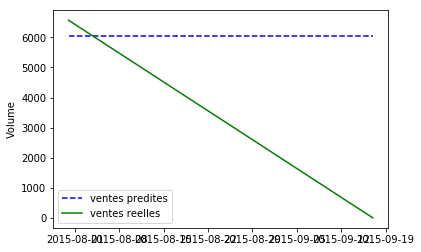

store:25


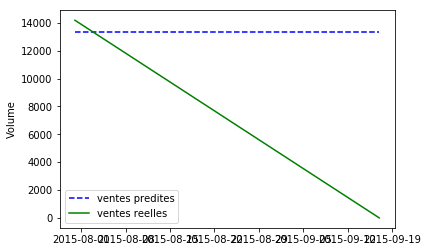

store:29


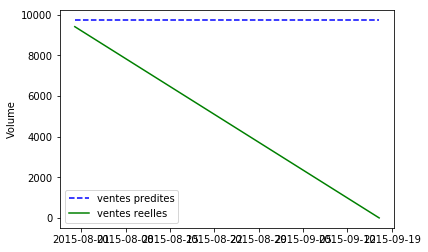

store:30


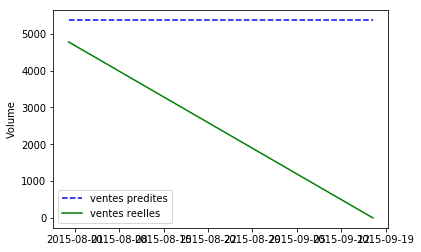

store:31


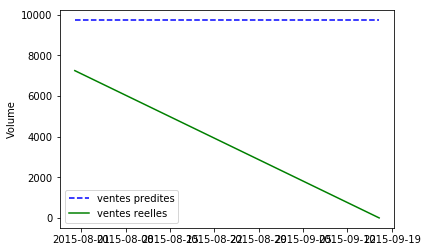

store:32


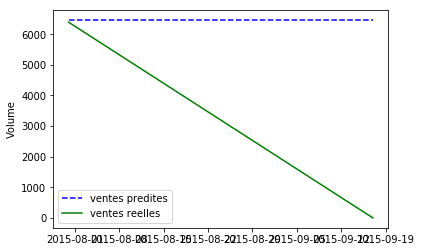

store:33


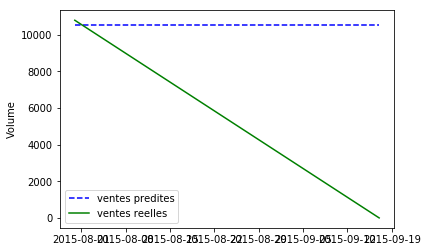

store:35


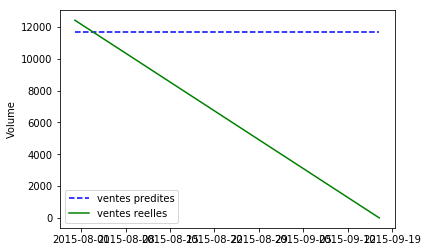

store:36


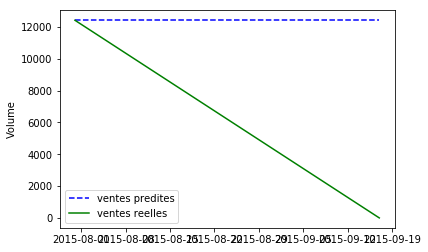

store:38


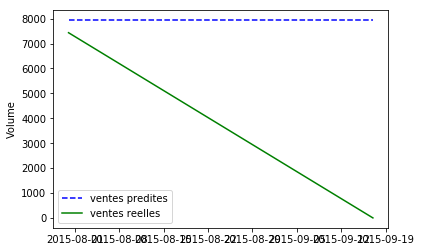

In [78]:
for store in best_stores:
    print('store:' + str(store))
    ax = plt.figure().gca()
    
    # on affiche à partir de Juin pour plus de lisibilité
    X_sales = shop_data_to_predict[shop_data_to_predict['Date'] > 20150600]
    X_sales = X_sales[X_sales['Store'] == store].set_index('Datetime')
    X_sales = X_sales.sort_index()
   
    plt.plot(X_sales['Sales_pred'],'b--', label='ventes predites')
    
    plt.plot(X_sales['Sales'],'g', label='ventes reelles')

    plt.ylabel('Volume')
    plt.legend()
    plt.show()

### Extraction des prédictions

In [79]:
df_to_submit = shop_data_to_predict[shop_data_to_predict['Sales'] == -1][['Id','Sales_pred']].astype('int')
df_to_submit['Sales'] = np.round(df_to_submit['Sales_pred']).astype('int')
df_to_submit = df_to_submit.sort_values('Id')
del df_to_submit['Sales_pred']

In [80]:
df_to_submit.head(5)

,Id,Sales
1,1,6227
4,2,8169
9,3,11538
11,4,6725
13,5,9520


In [81]:
df_to_submit.to_csv('vle_submission.csv', index=False)

#### Debrief
Ce tuto permet de montrer comment on peut rapidement avoir des résultats tout à fait correct avec peu d'effort de code pour la génération de features temporelles, le tout étant packagé et réutilisable pour chaque problème de ce type.